In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set()
import h5py
import matplotlib.lines as mlines
import gzip
import os

In [122]:
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from keras.models import load_model
from Bio import SeqIO

In [123]:
from Functions import position_gene, NFR_position, heat_map, calculate_nrl, process
from MyModuleLibrary.mykeras.losses import correlate, mae_cor

# Loading the data

The experimental data for S.cerevisiae are available with [accession number GSM552910](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM552910).

In [33]:
# We import the experimental landscape of nucleosome on chromosome 16 of S.cerevisiae to find the NFR.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba = pd.read_csv('./Start_data/proba_in_vivo.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]

In [ ]:
# We import here the prediction on chromosome 16 that we want to study.
y_pred = np.load('../Results_nucleosome/y_pred_CNN_nucleosome_in_vivo.npy')

Renormalisation of the data (this normalization correspond to the one experimentally used by [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414) to study the nucleosome occupancy). The normalization using a rolling max is shown to be less efficient to predict the nucleosome occupancy.

In [ ]:
y_pred /= np.mean(y_pred)
y_true /= np.mean(y_true)

Applying a moving average for both series

In [ ]:
length = 3

y_pred = np.array([np.mean(y_pred[i - length : i + length]) for i in range(length, len(y_pred) - length)])
y_true = np.array([np.mean(y_true[i - length : i + length]) for i in range(length, len(y_true) - length)])

In [ ]:
correlation = pearsonr(y_pred[y_true > 0], y_true[y_true > 0])[0]
print 'Correlation between true and pred :', correlation

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)
ax.plot(y_pred, 'b', label='prediction')
ax.plot(y_true, 'r', label='experimental')
ax.legend()
ax2 = fig.add_subplot(2,1,2)
ax2.hist(y_pred, bins=100, density=True,
         histtype='step', color='b', label='prediction')
ax2.hist(y_true, bins=100, density=True,
         histtype='step', color='r', label='experimental')
ax2.legend()
ax.set_title('Experimental and predicted occupancy on chr 16 ')
ax2.set_title('Experimental and predicted distribution of score on chr 16 ')

plt.show()

#  Mean nucleosome occupancy in TSS region

The nucleosome occupancy displays a characteristic pattern in TSS region that we want our model to be able to predict. This pattern is a relatively low nucleosome occupancy before the TSS followed by a regular positioning of nucleosome with the periodicity 167 in S.cerevisiae.

In [ ]:
gene_positions = pd.read_table('./Start_data/position_genes.txt', sep = '\t')
gene_positions.head()

In [ ]:
tss_occupancy_pred = heat_map(y_pred, y_true, gene_positions, HALF_WX, 'tss')
tss_occupancy_true = heat_map(y_true, y_true, gene_positions, HALF_WX, 'tss')

We look at the heat map of nucleosome occupancy in the TSS region (both predicted and experimental). The mean occupancy in this region displays the characteristic regular pattern.

In [ ]:
print 'Experimental NRL : {}'.format(calculate_nrl(tss_occupancy_true))
print 'Predicted NRL : {}'.format(calculate_nrl(tss_occupancy_pred))

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,3),dpi=100,num=1)

ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred, axis=0),
         color='b',
         label='prediction')
ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_true, axis=0),
         color='r',
         label='experimental')
ax1.set(title='Mean nucleosome occupancy near TSS',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax1.legend()

ax2.imshow(tss_occupancy_true, aspect='auto')
ax2.set(title='Experimental heat-map',
        xlabel='Distance from TSS')
ax2.set_xticks(np.arange(0, 1501, 250))
ax2.set_xticklabels(np.arange(-500, 1001, 250))

ax3.imshow(tss_occupancy_pred, aspect='auto')
ax3.set(title='Predicted heat-map',
        xlabel='Distance from TSS')
ax3.set_xticks(np.arange(0, 1501, 250))
ax3.set_xticklabels(np.arange(-500, 1001, 250))

The NFR are the determinant part of the prediction.

The precision of their prediction can be assess by representing the predicted distances between the TSS and the NFR in function of their experimental counterparts. 

Then we can plot the ratio of NFR that are predicted whitin a distance from the experimental NFR.

In [ ]:
nfr_pos_true = NFR_position(y_true, HALF_WX, gene_positions)
nfr_pos_pred = NFR_position(y_pred, HALF_WX, gene_positions)
gene_pos = position_gene(gene_positions, HALF_WX, y_true)

dist_TSS_NFR_true = np.append(np.abs(nfr_pos_true[nfr_pos_true.strand == '+'].nfr_pos.values - gene_pos[2]),
                              np.abs(nfr_pos_true[nfr_pos_true.strand == '-'].nfr_pos.values - gene_pos[3]))

dist_TSS_NFR_pred = np.append(np.abs(nfr_pos_pred[nfr_pos_pred.strand == '+'].nfr_pos.values - gene_pos[2]),
                              np.abs(nfr_pos_pred[nfr_pos_pred.strand == '-'].nfr_pos.values - gene_pos[3]))

diff = np.abs(nfr_pos_true.nfr_pos.values - nfr_pos_pred.nfr_pos.values)
ratios = np.array([len(diff[diff < i]) / float(len(diff)) for i in range(1000)])

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,5))

ax.plot(dist_TSS_NFR_true, dist_TSS_NFR_pred,
        linestyle='', marker='o', markersize=1.0, color ='royalblue')
ax.plot(range(100,800), range(0,700), linestyle='--', linewidth = 0.8, color = 'r')
ax.plot(range(0,800), range(100,900), linestyle='--', linewidth = 0.8, color = 'r')

ax.set(xlabel='Experimental distance from TSS to NFR',
       ylabel='Predicted distance from TSS to NFR',
       title='Scatter plot of NFR-TSS distances')

ax1.plot(ratios, color='royalblue',
         label='AUC : {}'.format(round(np.sum(ratios)) / 1000.))
ax1.set(title='Ratio of predicted NFR',
        ylabel='ratio of predicted NFR within the distance',
        xlabel='distance from real NFR')
ax1.legend()

## Evaluating the quality of the prediction in function of the gene activity

It is likely that the quality of prediction on a gene is anti-correlated with the gene activity. In fact the RNA-polymerase can change the organisation of the nucleosome during transcription adding noise to their structure. It is likely that this noise is dependant on the activity of the gene.

In [ ]:
rna_seq = pd.read_csv('./Start_data/rna_seq_SRR7131299.csv')
rna_seq = rna_seq[rna_seq.chr == 'chr16'].value.values
rna_seq = np.abs(rna_seq)

gene_pos_start, gene_pos_stop, _, _ = position_gene(gene_positions, HALF_WX, y_true)
gene_pos = zip(gene_pos_start, gene_pos_stop)

In [ ]:
genes_activity = np.array([np.mean(rna_seq[start : stop], axis=0) for start, stop in gene_pos])
genes_prediction_qual = np.array([pearsonr(y_true[start : stop],
                                           y_pred[start : stop])[0] for start, stop in gene_pos])

genes_activity = genes_activity[~np.isnan(genes_prediction_qual)]
genes_prediction_qual = genes_prediction_qual[~np.isnan(genes_prediction_qual)]

fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.plot(genes_activity,
        genes_prediction_qual,
        label='correlation : {}'.format(pearsonr(genes_activity, genes_prediction_qual)[0]),
        color='royalblue',
        marker='o',
        linestyle='',
        markersize=0.9)
ax.set(title='Prediction quality vs genes activity',
       xlabel='mean gene activity',
       ylabel='correlation between pred and true on the gene')
ax.legend()

## Evaluating the prediction in several other species

We predict on several different species the nucleosome occupancy with the model trained on S.cerevisiae.
We want to observe if the model is able to adapt to a new genome, and especially to look at its periodicity adaptation.

To be more precise the evaluation is made on :
    - K.lactis, chr 6
    - D.hansenii, chr 3
    - C.albicans, chr 1
    - Y.lipolytica, chr 1
The experimental landscape in vivo were taken from the study of [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414) and are available with [accession number GSE21960](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE21960)

In [ ]:
# We import the experimental landscape of nucleosome on several species.
WINDOW = 2001
HALF_WX = WINDOW // 2

proba_klac = pd.read_csv('./Start_data/proba_klac.csv')
y_klac = proba_klac[proba_klac.chr == 'chr6'].value.values[HALF_WX : - HALF_WX]

proba_dhan = pd.read_csv('./Start_data/proba_dhan.csv')
y_dhan = proba_dhan[proba_dhan.chr == 'chr3'].value.values[HALF_WX : - HALF_WX]

proba_calb = pd.read_csv('./Start_data/proba_calb.csv')
y_calb = proba_calb[proba_calb.chr == 'chr1'].value.values[HALF_WX : - HALF_WX]

proba_ylip = pd.read_csv('./Start_data/proba_ylip.csv')
y_ylip = proba_ylip[proba_ylip.chr == 'chr1'].value.values[HALF_WX : - HALF_WX]

In [ ]:
y_pred_klac = np.load('../Results_nucleosome/y_pred_klac.npy')
y_pred_dhan = np.load('../Results_nucleosome/y_pred_dhan.npy')
y_pred_calb = np.load('../Results_nucleosome/y_pred_calb.npy')
y_pred_ylip = np.load('../Results_nucleosome/y_pred_ylip.npy')

In [ ]:
gene_klac = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Klac.chrF.csv')
gene_klac = gene_klac[gene_klac.type == 'gene']

gene_dhan = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Dhan.chrC.csv')
gene_dhan = gene_dhan[gene_dhan.type == 'gene']

gene_calb = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Calb.chrA.csv')
gene_calb = gene_calb[gene_calb.type == 'gene']

gene_ylip = pd.read_csv('./Start_data/Tsankov_dataset/position_genes_Ylip.chrA.csv')
gene_ylip = gene_ylip[gene_ylip.type == 'gene']

In [ ]:
feature = 'nuc_pred'

tss_occupancy_pred_klac = heat_map(y_pred_klac, y_klac, gene_klac, HALF_WX, feature)
tss_occupancy_klac = heat_map(y_klac, y_klac, gene_klac, HALF_WX, feature)

tss_occupancy_pred_dhan = heat_map(y_pred_dhan, y_dhan, gene_dhan, HALF_WX, feature)
tss_occupancy_dhan = heat_map(y_dhan, y_dhan, gene_dhan, HALF_WX, feature)

tss_occupancy_pred_calb = heat_map(y_pred_calb, y_calb, gene_calb, HALF_WX, feature)
tss_occupancy_calb = heat_map(y_calb, y_calb, gene_calb, HALF_WX, feature)

tss_occupancy_pred_ylip = heat_map(y_pred_ylip, y_ylip, gene_ylip, HALF_WX, feature)
tss_occupancy_ylip = heat_map(y_ylip, y_ylip, gene_ylip, HALF_WX, feature)

#### Evaluating the Nucleosome Repeat Length

In [ ]:
nrl_klac = calculate_nrl(tss_occupancy_klac)
nrl_pred_klac = calculate_nrl(tss_occupancy_pred_klac)

nrl_dhan = calculate_nrl(tss_occupancy_dhan)
nrl_pred_dhan = calculate_nrl(tss_occupancy_pred_dhan)

nrl_calb = calculate_nrl(tss_occupancy_calb)
nrl_pred_calb = calculate_nrl(tss_occupancy_pred_calb)

nrl_ylip = calculate_nrl(tss_occupancy_ylip)
nrl_pred_ylip = calculate_nrl(tss_occupancy_pred_ylip)

In [ ]:
N = 4
nrl_true = (nrl_klac, nrl_dhan, nrl_calb, nrl_ylip)
nrl_pred = (nrl_pred_klac, nrl_pred_dhan, nrl_pred_calb, nrl_pred_ylip)

ind = np.arange(N) 
width = 0.35       

fig, ax = plt.subplots(1, 1)
ax.bar(ind, nrl_true, width, label='Experimental NRL', color='red')
ax.bar(ind + width, nrl_pred, width, label='Predicted NRL', color='blue')

ax.set(ylabel='Nucleosome Repeat Length',
       title='Experimental and predicted NRL for the four species')
ax.set_ylim(150, 179)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['Klac', 'Dhan', 'Calb', 'Ylip'])
ax.legend(loc='best')

plt.show()

The predicted NRL is somehow always the same, around the NRL of S.cerevisiae. The model is able to learn the periodicity of the data but for S.cerevisiae, there is no code in the sequence that indicate the periodicity.

#### Plotting the mean occupancy in TSS region

We align the mean occupancy to the experimental N+1 so that to replicate the alignment in [Tsankov et al.](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000414).

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(8,8),dpi=100,num=1)

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_klac, axis=0),
         color='b',
         label='prediction')
ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_klac, axis=0),
         color='r',
         label='experimental')
ax1.set(title='K.lactis',
        ylabel='Mean occupancy')
ax1.legend()

ax2.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_dhan, axis=0),
         color='b',
         label='prediction')
ax2.plot(range(-500, 1000),
         np.mean(tss_occupancy_dhan, axis=0),
         color='r',
         label='experimental')
ax2.set(title='D.hansenii')
ax2.legend()

ax3.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_calb, axis=0),
         color='b',
         label='prediction')
ax3.plot(range(-500, 1000),
         np.mean(tss_occupancy_calb, axis=0),
         color='r',
         label='experimental')
ax3.set(title='C.albicans',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax3.legend()

ax4.plot(range(-500, 1000),
         np.mean(tss_occupancy_pred_ylip, axis=0),
         color='b',
         label='prediction')
ax4.plot(range(-500, 1000),
         np.mean(tss_occupancy_ylip, axis=0),
         color='r',
         label='experimental')
ax4.set(title='Y.lipolityca',
        xlabel='distance from TSS')
ax4.legend()

## Paired-end collaborator data

The data not published taken from our collaborator are paired end, we want to invetigate the influence of the alignment on the quality of prediction. The dataset is made of several replica of an experiment with an artificial part on the chromosome 13. In a first time we train a model on the first 12 chromosomes, validation on 14 and 15 and prediction on chromosome 16.

We want to investigate the quality of prediction and the reproducibility (compared to the experimental one). We will compare predictions to experiments, experiments to experiments and predictions to predictions with a correlation matrix.

In [124]:
def plot_cor_mat(indexes):
    WINDOW = 2001
    HALF_WX = WINDOW // 2

    data = pd.DataFrame()

    for index in indexes:

        proba = pd.read_csv('./Start_data/proba_' + index + '.csv')
        y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]
        y_true /= np.mean(y_true)
        data['y_true_' + index] = y_true
        
    for index in indexes:
        y_pred = np.load('../Results_nucleosome/y_pred_collaborator_' + index + '.npy')
        y_pred /= np.mean(y_pred)        
        data['y_pred_' + index] = y_pred
        

    corr = data.corr()

    fig, ax = plt.subplots(figsize=(7, 7))
    helper = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=40, fontsize='x-small', ha = 'left')
    plt.yticks(range(len(corr.columns)), corr.columns, rotation=60, fontsize='x-small', ha = 'right')
    fig.colorbar(helper, ax=ax)

<IPython.core.display.Javascript object>


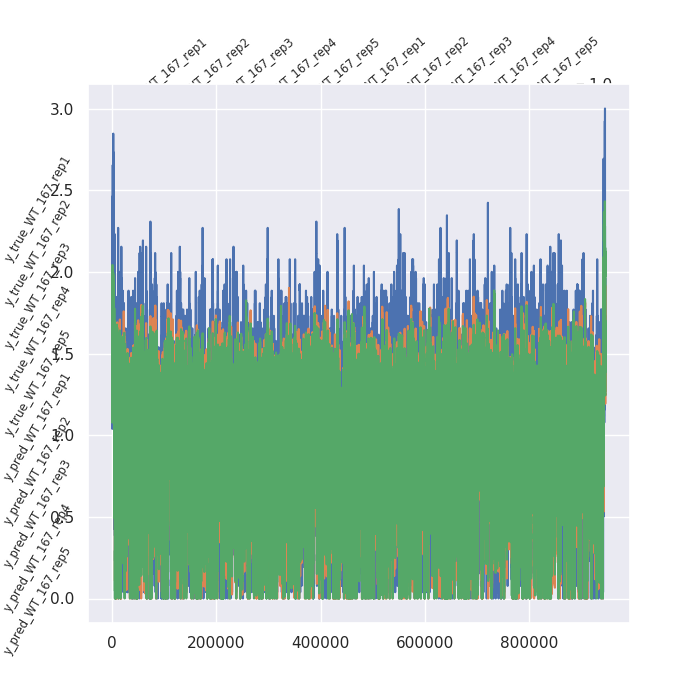

In [125]:
indexes = ['WT_167_rep1', 'WT_167_rep2', 'WT_167_rep3', 'WT_167_rep4', 'WT_167_rep5']
plot_cor_mat(indexes)

In [ ]:
indexes = ['WT_197_rep1', 'WT_197_rep2', 'WT_197_rep3', 'WT_197_rep4']
plot_cor_mat(indexes)

In [ ]:
indexes = ['WT_237_rep1', 'WT_237_rep2', 'WT_237_rep3', 'WT_237_rep4']
plot_cor_mat(indexes)

In [ ]:
indexes = ['WT_167_rep1', 'WT_197_rep1', 'WT_237_rep1']
plot_cor_mat(indexes)

### Collaborator data analysis

The gap in quality prediction make us wonder if the collaborator data are characteristic of nucleosome positioning or only of MNAse bias. We will compare those data with the original experiment analysed in the previous section.

In [150]:
data = pd.DataFrame()
proba = pd.read_csv('./Start_data/proba_in_vivo.csv')
y_original = proba[proba.chr == 'chr16'].value.values[HALF_WX : -HALF_WX]
data['original_data'] = y_original / np.mean(y_original)

indexes = ['WT_167_rep1', 'WT_167_rep2', 'WT_167_rep3', 'WT_167_rep4', 'WT_167_rep5',
           'WT_197_rep1', 'WT_197_rep2', 'WT_197_rep3', 'WT_197_rep4',
           'WT_237_rep1', 'WT_237_rep2', 'WT_237_rep3', 'WT_237_rep4']

for index in indexes:

    proba = pd.read_csv('./Start_data/proba_' + index + '.csv')
    y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : -HALF_WX]
    y_true /= np.mean(y_true)
    data[index] = y_true
        
indexes = [376, 369, 384, 385, 386, 387, 388]
dico = {376 : 'in_vitro_WCE', 369 : 'in_vitro_SGC', 384 : 'in_vitro_RSC', 385 : 'in_vitro_chd1',
        386 : 'in_vitro_ISW1a', 387 : 'in_vitro_ISW1b', 388 : 'in_vitro_ISW2'}

for index in indexes:
    proba = pd.read_csv('./Start_data/SRR2164' + str(index) + '_100bp.csv')
    y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]
    y_true /= np.mean(y_true)
    data[dico[index]] = y_true

corr = data.corr()

<IPython.core.display.Javascript object>


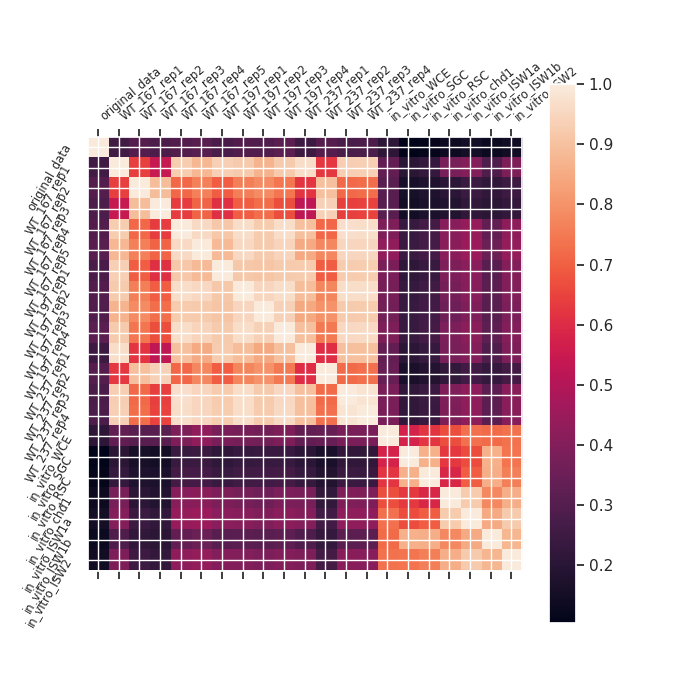

In [151]:
fig, ax = plt.subplots(figsize=(7, 7))
helper = ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=40, fontsize='x-small', ha = 'left')
plt.yticks(range(len(corr.columns)), corr.columns, rotation=60, fontsize='x-small', ha = 'right')
fig.colorbar(helper, ax=ax)

In [ ]:
gene_positions = pd.read_table('./Start_data/position_genes.txt', sep = '\t')

In [ ]:
tss_occupancy_original = heat_map(data.original_data,
                              data.original_data,
                              gene_positions, HALF_WX, 'tss')
index = 'y_collabo_WT_237_rep2'

tss_occupancy_col = heat_map(data[index],
                              data[index],
                              gene_positions, HALF_WX, 'tss')

NameError: name 'tss_occupancy_col' is not defined

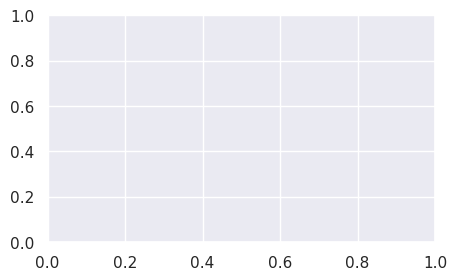

In [32]:
fig,ax1 = plt.subplots(1,1,figsize=(5,3),dpi=100,num=1)

ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_col, axis=0),
         color='b',
         label='collabo')
ax1.plot(range(-500, 1000),
         np.mean(tss_occupancy_original, axis=0),
         color='r',
         label='original')
ax1.set(title='Mean nucleosome occupancy near TSS',
        xlabel='distance from TSS',
        ylabel='Mean occupancy')
ax1.legend()

By looking at the mean nucleosome occupancy in TSS region it appears that the paired-end data do not display the typical periodical feature except for the three replica 167_rep2, 167_rep3, 237_rep2 where the model predict with the worse score. The good score of the model can be explained by the poor quality of the experimental data (that may be representative of the MNAse bias, a much more sequence driven problem).

### Multi-prediction analysis

Knowing that the replica 2 and 3 have a closer shape to the first experimental data than the other we try to predict with the same model the density of nucleosome given by different experiment (to be more general). We will compare the prediction of this model with a model direclty trained to predict the replica 2 and 3.

In [145]:
index = 'WT_167_rep2'
proba = pd.read_csv('./Start_data/proba_' + index + '.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]
y_true /= np.mean(y_true)
        
y_pred_single = np.load('../Results_nucleosome/y_pred_collaborator_' + index + '.npy')
y_pred_single /= np.mean(y_pred_single)

y_pred_multi = np.load('../Results_nucleosome/y_pred_WT_167_all_rep.npy')
#y_pred_multi = y_pred_multi[:, 1] / np.mean(y_pred_multi[:, 1])

In [152]:
index = 'WT_167_rep2'
proba = pd.read_csv('./Start_data/proba_' + index + '.csv')
y_true = proba[proba.chr == 'chr16'].value.values[HALF_WX : - HALF_WX]

<IPython.core.display.Javascript object>


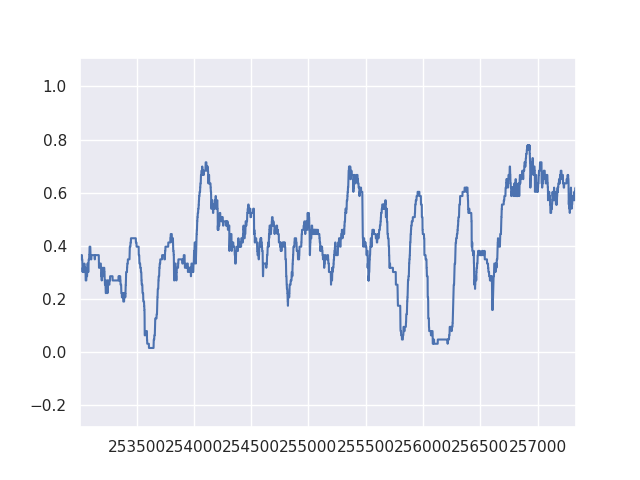

In [160]:
plt.plot(y_true / 63.)

In [136]:
pearsonr(y_true, y_pred_single)[0], pearsonr(y_true, y_pred_multi)[0], pearsonr(y_pred_single, y_pred_multi)[0]

(0.8098642756032238, 0.8095139647564562, 0.96951914)

<IPython.core.display.Javascript object>


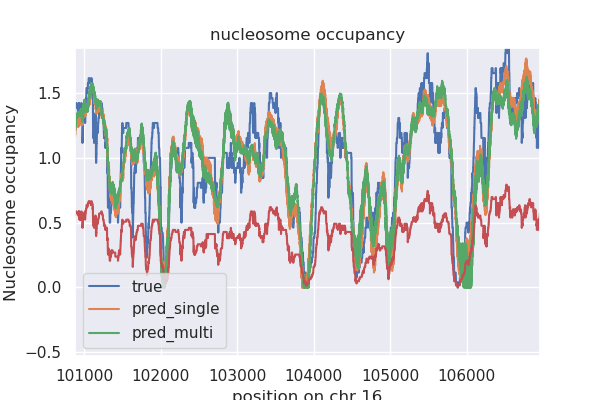

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=100, num=1)

ax.plot(y_true,
        label='true')
ax.plot(y_pred_single,
        label='pred_single')
ax.plot(y_pred_multi,
        label='pred_multi')
ax.set(title='nucleosome occupancy',
        xlabel='position on chr 16',
        ylabel='Nucleosome occupancy')
ax.legend()

There is no difference between the two way of training a model.

### Prediction on the synthetic domain

The collaborator includes a series of synthetic domains designed to precisely positioned the nucleosome on it.
We want to compare the prediction of our model on this sequence to the experiment.

In [4]:
def process_artificial_seq(start_601, length, n):
    """
        This function is aimed at creating the artificial sequence both for the prediction and to perform a bowtie
        alignment on it.
        
        It takes the position of the beginning of the 601_seq, the length of this sequence and the number of time
        that we want to repeat it and returns a sequence made of the 1000 bp before the 601, n times the 601 and
        the 1000 bp after the 601. It returns those sequence in a numpy array so that predict on it and also in a
        fasta file to perform and alignment on it using bowtie.
        
        Args:
            start_601: position of the beginning of 601_seq in the chromosome 13.
            length: {167, 197, 237} length of the 601
            n: number of time the 601 will be set on the artificial sequence.
        returns:
            seq_multi_601: numpy array with the artficial sequence.
            artificial_WT_length_nrepeat.fa: a fasta file with the artificial sequence
    """
    f = h5py.File('seq_chr_sacCer3/collaborator_' + str(length) + '/chr13.hdf5')
    seq = np.array(f['data'])
    f.close()
    
    seq_601 = seq[start_601 : start_601 + length]
    seq_multi_601 = seq[start_601 - 1000 : start_601]
    
    for i in range(n):
        seq_multi_601 = np.append(seq_multi_601, seq_601)
    
    seq_multi_601 = np.append(seq_multi_601, seq[start_601 + length : start_601 + length + 1000])
    
    fin = gzip.open('seq_chr_sacCer3/collaborator_' + str(length) + '/chr13.fa.gz', 'r')
    file_out = 'seq_chr_sacCer3/collaborator_' + str(length) + '/artificial_WT_' + str(length) + '_' + str(n) + 'rep.fa'

    for seq_record in SeqIO.parse(fin, 'fasta'):
        seq_601_fa = seq_record.seq[start_601 : start_601 + length]
        seq_multi_601_fa = seq_record.seq[start_601 - 1000: start_601]
        
        for i in range(n):
            seq_multi_601_fa = seq_multi_601_fa + seq_601_fa
    
        seq_multi_601_fa = seq_multi_601_fa + seq_record.seq[start_601 + length : start_601 + length + 1000]
        
        seq_record.seq = seq_multi_601_fa
        seq_record.id = 'KXIII_artificial_part'

        with open(file_out, 'w') as f_out:
            SeqIO.write(seq_record, f_out, 'fasta')
    
    return seq_multi_601
    

In [5]:
def align_seq(start_601, length, n, fastq_file, replica_num):
    """
        Return the experimental nucleosome occupancy on the artificial sequence for the experiment in fatsq_file, 
        corresponding to the replica number replica_num.
        
        This function will return a numpy array corresponding to the experimental nucleosome occupancy on the
        artificial sequence that is saved on a .csv file. If this .csv does not exist then it will perform the
        alignment and creates the .csv file. This operation may take a while.
        
        Args:
            start_601: position of the first nucleotid on the 601 synthetic sequence.
            length: length in bp of the 601 sequence.
            n: number of occurence of the 601 sequence in our designed seq.
            fastq_file: the file that contains the results of experiment in fastq format (path from Alignment)
            replica_num: the replica number of the experiment at this side (in our definition)
    """
    
    if not os.path.exists('Start_data/collaborator_chr13/artificial_WT_' + str(length) + '_' + str(n) + 'rep_rep' + str(replica_num) + '.csv'):
        seq_multi_601 = process_artificial_seq(start_601, length, n)
    
        os.chdir('/users/invites/routhier/Documents/Projet_nucleosomes/Alignment/')
        os.system("align_artificial.sh " + fastq_file  + " " + str(length) + " " + str(n) + " " + str(replica_num))
        os.chdir('/users/invites/routhier/Documents/Projet_nucleosomes/Programme/')
    
    y_true_syn = pd.read_csv('Start_data/collaborator_chr13/artificial_WT_' + str(length) + '_' + str(n) + 'rep_rep' + str(replica_num) + '.csv').value.values
    return y_true_syn

In [6]:
def predict_align_seq(start_601, length, n, model_length, replica_num):
    """Predict the nucleosome density on the artificial sequence with the model WT_(model_length)_rep(replica_num)"""
    seq_multi_601 = process_artificial_seq(start_601, length, n)
    x_seq = process(seq_multi_601)

    model = load_model('../Results_nucleosome/weights_collaborator_WT_' + str(model_length) + '_rep' + str(replica_num) + '.hdf5',
                        custom_objects={'mae_cor' : mae_cor, 'correlate' : correlate})
    y_pred_syn = model.predict(x_seq)
    return y_pred_syn

In [ ]:
start_601 = 793597
length = 167
n = 20

fastq_files = ['BC70_TACT.dat', 'BC172_CGGT.dat', 'BC174_CGTT.dat']
#fastq_files = ['BC78_ACTT.dat', 'BC110_CACT.dat','BC164_GTGT.dat']

replica_nums = [1, 4, 5]
#replica_nums = [1, 2, 4]

y_true_mean = np.zeros(n * length)
y_pred_mean = np.zeros(n * length)

for fastq_file, replica_num in zip(fastq_files, replica_nums):
    y_true_syn = align_seq(start_601, length, n, fastq_file, replica_num)
    y = y_true_syn[1000 : 1000 + n * length]
    plt.plot(y, label='y_true_mean')
    y_true_mean += y
    
#model_lengths = [167, 167, 167, 197, 197, 197, 197, 237, 237, 237]
#replica_nums = [1, 4, 5, 1, 2, 3, 4, 1, 3, 4]

#for model_length, replica_num in zip(model_lengths, replica_nums):
  #  y_pred_syn = predict_align_seq(start_601, length, n, model_length, replica_num)
    #y_pred_syn = [np.mean(y_pred_syn[i : i + 5]) for i in range(len(y_pred_syn) - 5)]
   # y_pred_mean += y_pred_syn[:, 0]

#plt.plot(y_true_mean / np.mean(y_true_mean), label='y_true_mean')
#plt.plot(y_pred_mean / np.mean(y_pred_mean), label='y_pred_mean')
#plt.legend()